# Clustering 
In this tutorial, we will apply K-Means clustering. k-means aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean. 

## Small theoretical recap
After deciding on the clusters number k, we initialize k means at random. The algorithm then proceeds by alternating between two steps: 
1. Assignment step: Assign each observation to the cluster whose mean has the least squared Euclidean distance
2. Update step: Calculate the new means to be the centroids of the observations in the new clusters.

The means will eventually move towards the center of the clusters. The algorithm has converged when the assignments no longer change. 
![ChessUrl](https://media0.giphy.com/media/12vVAGkaqHUqCQ/giphy.gif "kmeans right")

Note: There is no guarantee that the optimum is found using this algorithm. It is therefore wise to try different initialization values and compare the results. 
![ChessUrl](https://media1.giphy.com/media/3NKUcoyBzkXQc/giphy.gif "kmeans wrong")


## Step 0: Import packages 
Before we start, we need to load a couple of packages that we will need throughout the exercise.

In [3]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.stats import mode
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn is a visualization library based on matplotlib.
import numpy as np
import warnings; warnings.simplefilter('ignore')

## Step 1:  Load your data
The sklearn library offers a couple of standard datasets. We'll download the digits dataset, which consists of 1797 8x8 images of handwritten digits.

In [21]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape # the data attribute consists of 1797 feature-vectors of length 64 (8x8)

(1797, 64)

## Step 2: Take look at your data
Let's have a look at the first 4 images, stored in the 'images' attribute of the dataset. For these images, we know which digit they represent: it is given in the 'target' attribute.

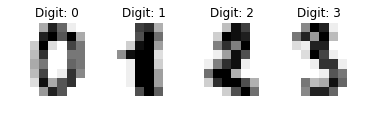

In [30]:
images_and_labels = list(zip(digits.images, digits.target))
for index, (image, label) in enumerate(images_and_labels[:4]):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('Digit: %i' % label)

plt.show()

## Step 3: Clustering
We already imported the kmeans algorithm at the very beginning of the script (i.e. KMEANS). Next to a number of default parameters, it requires one 1 obligatory parameter: 'n_clusters'. It represents the number of clusters or groups we expect to find within the data. Since we are trying to group digits, it should be obvious that n_clusters = 10 in this case.  

In [97]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape # contains the coordinates of the centers 

(10, 64)

## Step 5: Model Evaluation
Based on the center coordinates, we can create 10 new images and see how well they correspont to real digits. We will reshape the 10 vectors of length 64 back into a 8x8 format and plot them.  

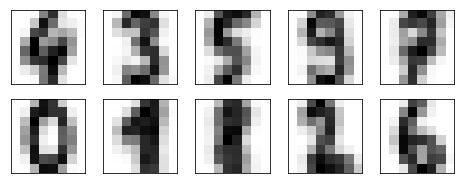

In [98]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.gray_r)
plt.show()

Next, we will compare the predictions to the true digit values (target). To determine to which digit each cluster belongs, we will label it with the most common target value of the cluster (i.e. the mode). We then use the accuracy_score() function to compare predictions with true values. It will tell us how many percent we grouped correctly.   

In [100]:
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0] # set label to most common target value of cluster i
accuracy_score(digits.target, labels)

0.79354479688369506

To get a more detailed view into the errors we made, we can visualize predicitions against true values in a confusion matrix and colour each field depending on its value (i.e. heatmap). 

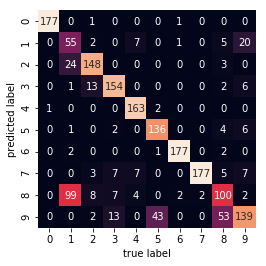

In [102]:
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');
plt.show()

Aside from some minor mistakes, the algorithm falsly labelled
- "1" as "8" 99 times, 
- "5" as "9" 43 times,
- "8" as "9" 53 times.

# Clustering for data reduction

In the above exercise, we used kmeans to group a dataset into more homogenous clusters. However, the same technique can also be used to simplify datasets (i.e. data reduction)

Below you can find a few lines of code that illustrates how we can create an accurate representation of a HD picture with a much smaller set of colours, using clustering.

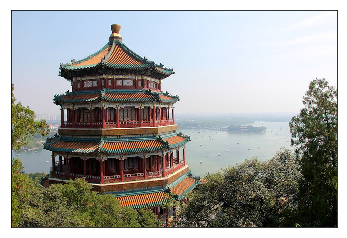

In [121]:
# Note: this requires the ``pillow`` package to be installed
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);
plt.show()

In [106]:
china.shape

(427, 640, 3)

In [109]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [114]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20)
    plt.show();
    

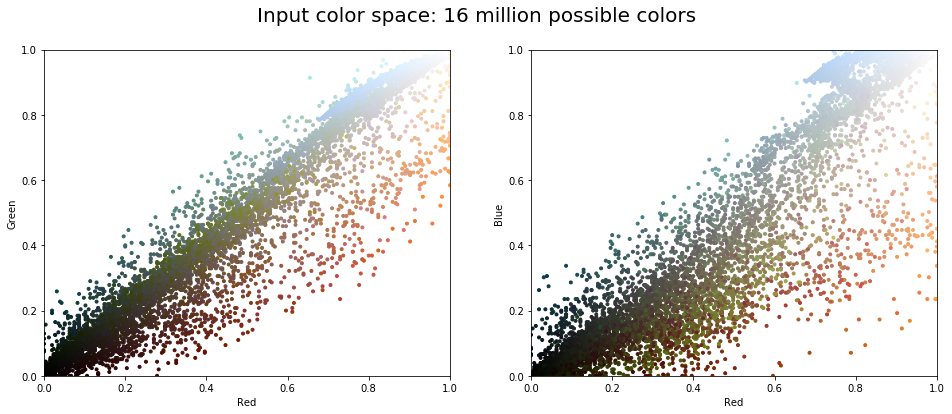

In [115]:
plot_pixels(data, title='Input color space: 16 million possible colors')

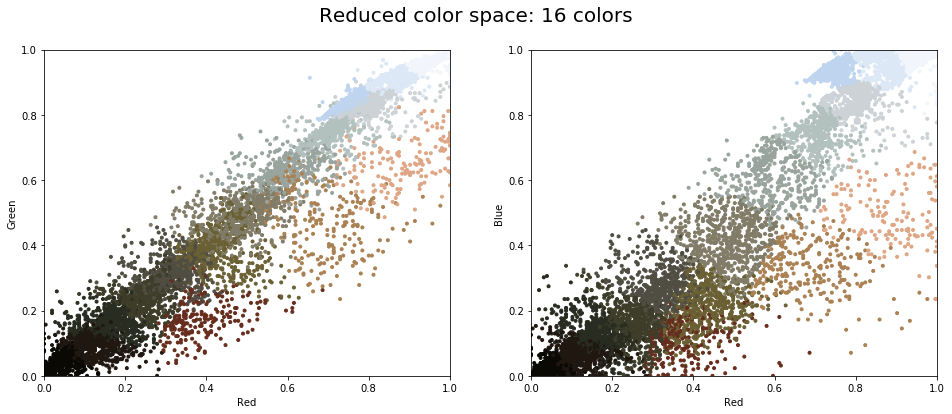

In [117]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

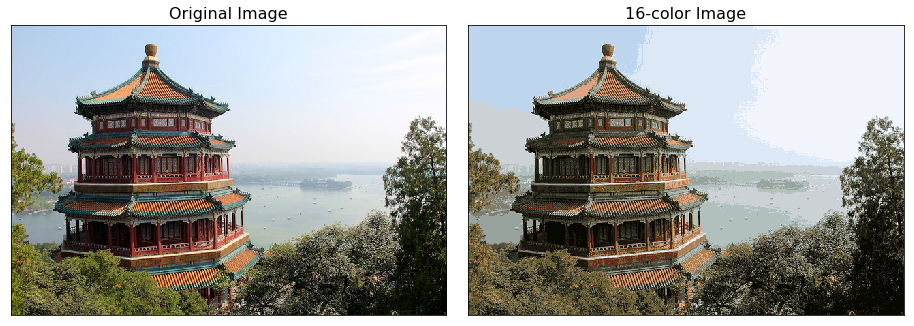

In [120]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16)
plt.show();